In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

In [6]:
class ActivationFunction(Enum):
    Tanh = 0
    Sigmoid = 1
    Sin = 2
    Cos = 3
    Atan = 4

In [7]:
class ActivationFunctionNeuralNetwork(nn.Module):
    '''Activation function of the neural network
    '''

    def __init__(self, activationFunction=ActivationFunction.Tanh):
        super(ActivationFunctionNeuralNetwork, self).__init__()
        self.activationFunction = activationFunction


    def forward(self, x):
        if self.activationFunction == ActivationFunction.Tanh:
            return F.tanh()

        elif self.activationFunction == ActivationFunction.Sigmoid:
            return F.sigmoid(x)

        elif self.activationFunction == ActivationFunction.Sin:
            return torch.sin(x)

        elif self.activationFunction == ActivationFunction.Cos:
            return torch.cos(x)

        elif self.activationFunction == ActivationFunction.Atan:
            return torch.atan(x)


class NeuralNet(nn.Module):
    ''' Neural Network used as a mapping function.
        Glorot initialisation. 
    '''
    def __init__(self, layers, activationFunction=ActivationFunction.Tanh):
        super(NeuralNet, self).__init__()

        self.layers = []

        for i in range(len(layers) - 2):
            self.layers.append(nn.Linear(in_features=layers[i], out_features=layers[i+1]))
            self.layers.append(ActivationFunctionNeuralNetwork(activationFunction))

        self.layers.append(nn.Linear(in_features=layers[-2], out_features=layers[-1]))
        self.model = nn.Sequential(*self.layers)
        self.model.apply(self._normal_init) 
            

    def _normal_init(self, layer):
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_normal_(layer.weight)


    def train(self, feedDict, lossFunction, iterations):
        xInt = feedDict['xInt']
        xBound = feedDic['xBound']
        boundaryCondition = feedDict['boundaryCondition']

        # default parameters to be customed
        optimiser = torch.optim.LBFGS(
            params=self.model.parameters(),
            lr=1,
            max_iter=20,
            max_eval=None,
            tolerance_grad=1e-07,
            tolerance_change=1e-09,
            history_size=100,
            line_search_fn=None
        )

        for epoch in range(iterations):
            yInt = self.model(xInt)
            yBound = self.model(xBound)
            loss = lossFunction(xInt, yInt, yBound, boundaryCondition)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        
    def predict(self, x):
        x = torch.tensor(x)
        return self.model(x)

In [8]:
class PDENeuralNetwork:
    def __init__(self, domain, network):
        self.network = network
        self.domain = domain
        self.boundaryDomainSize = []
        self.totalBoundaryDomainSize = 0
        for i in range(len(domain)):
            self.boundaryDomainSize.append(1)
            for j in range(len(domain)):
                if j != i:
                    self.boundaryDomainSize[i] = self.boundaryDomainSize[i] * (self.domain[j][1] - self.domain[j][0])
            self.totalBoundaryDomainSize = self.totalBoundaryDomainSize + 2 * self.boundaryDomainSize[i]


    def SampleData(self, interiorPointCount, boundaryPointCount, validate=False, lossWeight=None):
        feedDict = {}

        xInt = self.SampleInteriorX(interiorPointCount)
        xBound = self.SampleBoundaryX(boundaryPointCount)
        boundaryCondition = self.BoundaryCondition(xBound)
        if validate:
            xInt = self.SampleInteriorX(interiorPointCount)
            xBound = self.SampleBoundaryX(boundaryPointCount)
            boundaryCondition = self.BoundaryCondition(xBound)

            feedDict['xIntValidate'] = xInt
            feedDict['xBoundValidate'] = xBound
            feedDict['boundaryConditionValidate'] = boundaryCondition

        feedDict['xInt'] = xInt
        feedDict['xBound'] = xBound
        feedDict['boundaryCondition'] = boundaryCondition

        return feedDict

    def sampleInteriorX(self, pointCount):
        ''' Sample points from the domain. Eg domain = [(0, 1), (0, 1)]
            This means sampling in every direction pointCount.
        '''
        if pointCount < 1:
            pointCount = 1

        xInt = []
        for i in range(len(self.domain)):
            xInt.append(np.random.uniform(self.domain[i][0], self.domain[i][1], (pointCount, 1)))
        return xInt

    # Sample uniform collocation points on the boundary of the domain
    def sampleBoundaryX(self, pointCount):
        ''' Sample points from the boundaries
        '''
        if pointCount < 2 * len(self.domain):
            pointCount = 2 * len(self.domain)

        xBound = []
        # Iterate over dimensions
        for i in range(len(self.domain)):
            xBound.append(np.empty((0, 1), dtype=np.float64))

            # Iterate over boundaries 
            for j in range(len(self.domain)):
                for bound in self.domain[j]:
                    newPoints = max(int(pointCount * self.boundaryDomainSize[j] / self.totalBoundaryDomainSize), 1)
                    if j == i:
                        newX = np.full((newPoints, 1), bound, dtype=np.float64)
                    else:
                        newX = np.random.uniform(self.domain[j][0], self.domain[j][1],
                                                    (newPoints, 1))
                    xBound[i] = np.concatenate((xBound[i], newX))

        return xBound


    def PartialDerivative(tensor, variable, order=1):
        if order == 1:
            torch.autograd.grad(
                outputs=[tensor],
                inputs=[variable],
                grad_outputs=torch.ones_like(tensor),
                allow_unused=True,
                retain_graph=True,
                create_graph=True
            )[0]

        elif order == 2:
            # for Laplace operator, take the trace of the hessian 
            torch.autograd.functional.hessian(func=self.model(), inputs=variable)

        else:
            raise NotImplementedError


    def train(self, lossFunction, iterations):
        feedDict = self.SampleData(interiorPointCount=interiorPointCount,
                                   boundaryPointCount=boundaryPointCount,
                                   validate=False,
                                   lossWeight=lossWeight)


        self.network.train(feedDict, lossFunction, iterations)

In [9]:
class LaplaceBase(PDENeuralNetwork):
    def ComputeLossTerms(domain, xInt, yInt, yBound, boundaryCondition):
        gradients = [PDENeuralNetwork.PartialDerivative(yInt, xInt[i], 2)
                     for i in range(len(domain))]
        lossInt = tf.reduce_mean(tf.square(tf.add_n(gradients)))
        magnitudeInt = tf.reduce_mean(tf.square(tf.add_n([tf.abs(grads) for grads in gradients])))
        lossBound = tf.reduce_mean(tf.square(yBound - boundaryCondition))
        magnitudeBound = tf.reduce_mean(tf.square(boundaryCondition))

        return lossInt, magnitudeInt, lossBound, magnitudeBound

In [ ]:
network = NeuralNet([2, 10, 10, 1], ActivationFunction.Sigmoid)
domain = [(0, 1), (0, 1)]

In [ ]:
pde = PDENeuralNetwork(domain, network)

In [ ]:
xInt = pde.SampleInteriorX(100)

In [ ]:
xBound = pde.SampleBoundaryX(100)

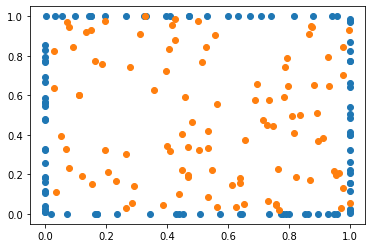

In [ ]:
plt.scatter(np.array(xBound)[0,:,0], np.array(xBound)[1,:,0])
plt.scatter(np.array(xInt)[0,:,0], np.array(xInt)[1,:,0]);